In [1]:
# ============================================
# 🧩 Imagenette2-320 → Uformer 학습 데이터 변환기
#   (노이즈 + 블러 열화 / 마스크 불필요)
# ============================================

import os
import random
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil

In [9]:
# ====== 1️⃣ 경로 설정 ======
SRC_DIR = "/content/drive/MyDrive/Advanced_Project/imagenette2-320"   # 원본 Imagenette 폴더
DST_DIR = "/content/drive/MyDrive/Advanced_Project/uformer_dataset"          # 결과 저장 경로

# Uformer 구조에 맞게 디렉터리 생성
for split in ["train", "val"]:
    for sub in ["input", "gt"]:
        os.makedirs(f"{DST_DIR}/{split}/{sub}", exist_ok=True)

In [10]:
# ====== 2️⃣ 유틸 함수 ======
def add_noise_and_blur(img):
    """노이즈 + 블러를 합성하여 열화된 이미지 생성"""
    # 가우시안 노이즈 추가
    noise = np.random.normal(0, 15, img.shape)
    noisy = np.clip(img + noise, 0, 255).astype(np.uint8)

    # 랜덤 블러 (kernel 3~7)
    k = random.choice([3, 5, 7])
    degraded = cv2.GaussianBlur(noisy, (k, k), sigmaX=1.2)
    return degraded


In [11]:
# train/val 폴더 그대로 사용
for split in ["train", "val"]:
    split_dir = os.path.join(SRC_DIR, split)
    for cls in os.listdir(split_dir):
        cls_dir = os.path.join(split_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Processing {split}/{cls}"):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            path = os.path.join(cls_dir, fname)
            img = Image.open(path).convert("RGB").resize((320, 320))
            img_np = np.array(img)
            degraded = add_noise_and_blur(img_np)

            base_name = f"{cls}_{os.path.splitext(fname)[0]}.png"
            Image.fromarray(degraded).save(f"{DST_DIR}/{split}/input/{base_name}")
            img.save(f"{DST_DIR}/{split}/gt/{base_name}")

Processing val/n03000684: 100%|██████████| 386/386 [00:46<00:00,  8.23it/s]


In [15]:
# ====== Uformer 학습 실행 ======
# Uformer repo가 Colab에 없다면 먼저 클론
if not os.path.exists("/content/Uformer"):
    !git clone https://github.com/ZhendongWang6/Uformer.git

# 기존 PyTorch 제거
!pip uninstall -y torch torchvision torchaudio

# Colab에서 호환되는 최신 PyTorch 설치
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 125.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 152.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [17]:
os.chdir("/content/Uformer")
# 1. requirements.txt에서 torch 관련 라인 삭제
!sed -i '/torch/d' /content/Uformer/requirements.txt
!sed -i '/torchvision/d' /content/Uformer/requirements.txt
!sed -i '/torchaudio/d' /content/Uformer/requirements.txt

# 2. 나머지 패키지 설치
!pip install -r /content/Uformer/requirements.txt

In [22]:
# ====== 경로 설정 ======
SRC_DIR = "/content/drive/MyDrive/Advanced_Project/imagenette2-320"  # 원본 데이터셋 상위 폴더
DST_DIR = "/content/drive/MyDrive/Advanced_Project/uformer_dataset"                                  # Uformer 학습용 데이터셋
CKPT_DIR = "/content/drive/MyDrive/Advanced_Project"

In [23]:
# ====== Uformer 학습 실행 ======
# 학습 명령 실행
!python train.py \
  --train_dir /content/uformer_dataset/train \
  --val_dir /content/uformer_dataset/val \
  --arch Uformer_B \
  --train_ps 128 \
  --batch_size 16 \
  --lr_initial 1e-4 \
  --nepoch 200 \
  --gpu_id 0 \
  --ckpt_dir {CKPT_DIR}

python3: can't open file '/content/Uformer/train.py': [Errno 2] No such file or directory


In [24]:
# ======================================
# uformer_trainer.py (imagenette2-320용)
# ======================================

import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from model import UNet  # model.py에서 UNet 사용
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# ====== 데이터셋 정의 ======
class RestorationDataset(Dataset):
    def __init__(self, input_dir, gt_dir, transform=None):
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir)])
        self.gt_paths = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_paths[idx]).convert("RGB")
        gt_img = Image.open(self.gt_paths[idx]).convert("RGB")
        if self.transform:
            input_img = self.transform(input_img)
            gt_img = self.transform(gt_img)
        return input_img, gt_img

# ====== 경로 설정 ======
TRAIN_INPUT = "/content/drive/MyDrive/Advanced_Project/uformer_dataset/train/input"
TRAIN_GT = "/content/drive/MyDrive/Advanced_Project/uformer_dataset/train/gt"
VAL_INPUT = "/content/drive/MyDrive/Advanced_Project/uformer_dataset/val/input"
VAL_GT = "/content/drive/MyDrive/Advanced_Project/uformer_dataset/val/gt"
CKPT_DIR = "/content/drive/MyDrive/Advanced_Project/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

# ====== 변환 정의 ======
transform = transforms.Compose([
    transforms.ToTensor(),
])

# ====== DataLoader ======
train_dataset = RestorationDataset(TRAIN_INPUT, TRAIN_GT, transform=transform)
val_dataset = RestorationDataset(VAL_INPUT, VAL_GT, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# ====== 모델 정의 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(dim=32).to(device)

# ====== 손실 및 옵티마이저 ======
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # 20 epoch마다 LR 절반

# Mixed precision
scaler = GradScaler()

# ====== 학습 루프 ======
num_epochs = 50
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, gts in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        inputs, gts = inputs.to(device), gts.to(device)
        optimizer.zero_grad()
        with autocast():  # mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, gts)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # ====== Validation ======
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, gts in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            inputs, gts = inputs.to(device), gts.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, gts)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # ====== Checkpoint 저장 ======
    ckpt_path = os.path.join(CKPT_DIR, f"uformer_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, ckpt_path)

    # best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_ckpt_path = os.path.join(CKPT_DIR, f"uformer_best.pth")
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"✅ Best checkpoint saved: {best_ckpt_path}")

    scheduler.step()


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/tmp/ipython-input-2381456526.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train Epoch 1:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipython-input-2381456526.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Val Epoch 1:   0%|          | 0/246 [00:00<?, ?it/s]/tmp/ipython-input-2381456526.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val Epoch 1: 100%|██████████| 246/246 [00:35<00:00,  6

Epoch [1/50] Train Loss: 0.0291, Val Loss: 0.0275
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 2: 100%|██████████| 246/246 [00:35<00:00,  6.93it/s]


Epoch [2/50] Train Loss: 0.0263, Val Loss: 0.0259
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 3: 100%|██████████| 246/246 [00:34<00:00,  7.06it/s]


Epoch [3/50] Train Loss: 0.0251, Val Loss: 0.0247
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 4: 100%|██████████| 246/246 [00:35<00:00,  7.02it/s]


Epoch [4/50] Train Loss: 0.0240, Val Loss: 0.0232
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 5: 100%|██████████| 246/246 [00:34<00:00,  7.09it/s]


Epoch [5/50] Train Loss: 0.0221, Val Loss: 0.0221
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 6: 100%|██████████| 246/246 [00:34<00:00,  7.09it/s]


Epoch [6/50] Train Loss: 0.0209, Val Loss: 0.0208
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 7: 100%|██████████| 246/246 [00:35<00:00,  6.95it/s]


Epoch [7/50] Train Loss: 0.0203, Val Loss: 0.0202
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 8: 100%|██████████| 246/246 [00:36<00:00,  6.78it/s]


Epoch [8/50] Train Loss: 0.0198, Val Loss: 0.0198
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 9: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s]


Epoch [9/50] Train Loss: 0.0195, Val Loss: 0.0195
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 10: 100%|██████████| 246/246 [00:35<00:00,  6.92it/s]


Epoch [10/50] Train Loss: 0.0193, Val Loss: 0.0194
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 11: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s]


Epoch [11/50] Train Loss: 0.0190, Val Loss: 0.0190
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 12: 100%|██████████| 246/246 [00:35<00:00,  6.93it/s]


Epoch [12/50] Train Loss: 0.0188, Val Loss: 0.0189
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 13: 100%|██████████| 246/246 [00:34<00:00,  7.03it/s]


Epoch [13/50] Train Loss: 0.0185, Val Loss: 0.0187
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 14: 100%|██████████| 246/246 [00:35<00:00,  6.99it/s]


Epoch [14/50] Train Loss: 0.0183, Val Loss: 0.0188


Val Epoch 15: 100%|██████████| 246/246 [00:34<00:00,  7.03it/s]


Epoch [15/50] Train Loss: 0.0181, Val Loss: 0.0185
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 16: 100%|██████████| 246/246 [00:35<00:00,  7.00it/s]


Epoch [16/50] Train Loss: 0.0180, Val Loss: 0.0180
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 17: 100%|██████████| 246/246 [00:34<00:00,  7.08it/s]


Epoch [17/50] Train Loss: 0.0178, Val Loss: 0.0180


Val Epoch 18: 100%|██████████| 246/246 [00:34<00:00,  7.04it/s]


Epoch [18/50] Train Loss: 0.0177, Val Loss: 0.0178
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 19: 100%|██████████| 246/246 [00:34<00:00,  7.07it/s]


Epoch [19/50] Train Loss: 0.0175, Val Loss: 0.0177
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 20: 100%|██████████| 246/246 [00:35<00:00,  7.00it/s]


Epoch [20/50] Train Loss: 0.0174, Val Loss: 0.0178


Val Epoch 21: 100%|██████████| 246/246 [00:34<00:00,  7.11it/s]


Epoch [21/50] Train Loss: 0.0172, Val Loss: 0.0173
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 22: 100%|██████████| 246/246 [00:34<00:00,  7.04it/s]


Epoch [22/50] Train Loss: 0.0171, Val Loss: 0.0173
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 23: 100%|██████████| 246/246 [00:34<00:00,  7.11it/s]


Epoch [23/50] Train Loss: 0.0170, Val Loss: 0.0173
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 24: 100%|██████████| 246/246 [00:34<00:00,  7.12it/s]


Epoch [24/50] Train Loss: 0.0170, Val Loss: 0.0172
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 25: 100%|██████████| 246/246 [00:34<00:00,  7.09it/s]


Epoch [25/50] Train Loss: 0.0169, Val Loss: 0.0172


Val Epoch 26: 100%|██████████| 246/246 [00:34<00:00,  7.05it/s]


Epoch [26/50] Train Loss: 0.0168, Val Loss: 0.0171
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 27: 100%|██████████| 246/246 [00:34<00:00,  7.07it/s]


Epoch [27/50] Train Loss: 0.0168, Val Loss: 0.0170
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 28: 100%|██████████| 246/246 [00:35<00:00,  7.02it/s]


Epoch [28/50] Train Loss: 0.0168, Val Loss: 0.0170
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 29: 100%|██████████| 246/246 [00:35<00:00,  6.96it/s]


Epoch [29/50] Train Loss: 0.0168, Val Loss: 0.0170


Val Epoch 30: 100%|██████████| 246/246 [00:34<00:00,  7.05it/s]


Epoch [30/50] Train Loss: 0.0167, Val Loss: 0.0169
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 31: 100%|██████████| 246/246 [00:36<00:00,  6.74it/s]


Epoch [31/50] Train Loss: 0.0166, Val Loss: 0.0171


Val Epoch 32: 100%|██████████| 246/246 [00:36<00:00,  6.76it/s]


Epoch [32/50] Train Loss: 0.0166, Val Loss: 0.0168
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 33: 100%|██████████| 246/246 [00:34<00:00,  7.08it/s]


Epoch [33/50] Train Loss: 0.0166, Val Loss: 0.0168


Val Epoch 34: 100%|██████████| 246/246 [00:35<00:00,  7.02it/s]


Epoch [34/50] Train Loss: 0.0165, Val Loss: 0.0168
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 35: 100%|██████████| 246/246 [00:37<00:00,  6.56it/s]


Epoch [35/50] Train Loss: 0.0165, Val Loss: 0.0169


Val Epoch 36: 100%|██████████| 246/246 [00:35<00:00,  6.94it/s]


Epoch [36/50] Train Loss: 0.0165, Val Loss: 0.0167
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 37: 100%|██████████| 246/246 [00:37<00:00,  6.55it/s]


Epoch [37/50] Train Loss: 0.0164, Val Loss: 0.0166
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 38: 100%|██████████| 246/246 [00:35<00:00,  6.97it/s]


Epoch [38/50] Train Loss: 0.0164, Val Loss: 0.0168


Val Epoch 39: 100%|██████████| 246/246 [00:35<00:00,  7.00it/s]


Epoch [39/50] Train Loss: 0.0164, Val Loss: 0.0166
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 40: 100%|██████████| 246/246 [00:36<00:00,  6.80it/s]


Epoch [40/50] Train Loss: 0.0163, Val Loss: 0.0166
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 41: 100%|██████████| 246/246 [00:35<00:00,  6.93it/s]


Epoch [41/50] Train Loss: 0.0163, Val Loss: 0.0165
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 42: 100%|██████████| 246/246 [00:35<00:00,  6.94it/s]


Epoch [42/50] Train Loss: 0.0162, Val Loss: 0.0165


Val Epoch 43: 100%|██████████| 246/246 [00:35<00:00,  6.91it/s]


Epoch [43/50] Train Loss: 0.0162, Val Loss: 0.0165
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 44: 100%|██████████| 246/246 [00:35<00:00,  6.90it/s]


Epoch [44/50] Train Loss: 0.0162, Val Loss: 0.0165


Val Epoch 45: 100%|██████████| 246/246 [00:35<00:00,  6.92it/s]


Epoch [45/50] Train Loss: 0.0162, Val Loss: 0.0164
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 46: 100%|██████████| 246/246 [00:35<00:00,  6.93it/s]


Epoch [46/50] Train Loss: 0.0162, Val Loss: 0.0164


Val Epoch 47: 100%|██████████| 246/246 [00:35<00:00,  6.94it/s]


Epoch [47/50] Train Loss: 0.0162, Val Loss: 0.0164
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 48: 100%|██████████| 246/246 [00:35<00:00,  6.98it/s]


Epoch [48/50] Train Loss: 0.0162, Val Loss: 0.0164
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 49: 100%|██████████| 246/246 [00:34<00:00,  7.23it/s]


Epoch [49/50] Train Loss: 0.0162, Val Loss: 0.0164
✅ Best checkpoint saved: /content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth


Val Epoch 50: 100%|██████████| 246/246 [00:34<00:00,  7.17it/s]


Epoch [50/50] Train Loss: 0.0161, Val Loss: 0.0164


In [27]:
# ======================================
# batch_inference_uformer.py
# ======================================

import torch
from PIL import Image
from torchvision import transforms
from model import UNet
import os
import torch.nn.functional as F

# ====== 경로 설정 ======
CHECKPOINT = "/content/drive/MyDrive/Advanced_Project/checkpoints/uformer_best.pth"
INPUT_FOLDER = "/content/drive/MyDrive/Advanced_Project/test_images"  # 테스트할 이미지 폴더
OUTPUT_FOLDER = "/content/drive/MyDrive/Advanced_Project/test_results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ====== device ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== 모델 로드 ======
model = UNet(dim=32).to(device)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
model.eval()

# ====== 이미지 전처리 ======
transform = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ====== 배치 추론 ======
for fname in os.listdir(INPUT_FOLDER):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    input_path = os.path.join(INPUT_FOLDER, fname)
    img = Image.open(input_path).convert("RGB")
    orig_w, orig_h = img.size
    img_tensor = transform(img).unsqueeze(0).to(device)  # (1, C, H, W)

    # ====== UNet skip 연결 맞춤 ======
    # UNet 내부 업샘플/concat 크기 mismatch 방지
    def pad_to_divisible(x, div=16):
        _, _, h, w = x.size()
        pad_h = (div - h % div) % div
        pad_w = (div - w % div) % div
        return F.pad(x, (0, pad_w, 0, pad_h)), h, w

    padded_tensor, orig_h, orig_w = pad_to_divisible(img_tensor, div=16)

    # ====== 복원 ======
    with torch.no_grad():
        output_tensor = model(padded_tensor)

    # crop 원래 크기로
    output_tensor = output_tensor[:, :, :orig_h, :orig_w]

    # ====== 후처리 및 저장 ======
    output_img = output_tensor.squeeze(0).cpu()
    output_img = to_pil(output_img.clamp(0, 1))
    output_path = os.path.join(OUTPUT_FOLDER, fname)
    output_img.save(output_path)
    print(f"✅ 복원 완료: {output_path}")

print("🎉 모든 이미지 복원 완료")


✅ 복원 완료: /content/drive/MyDrive/Advanced_Project/test_results/TEST6.JPEG
🎉 모든 이미지 복원 완료


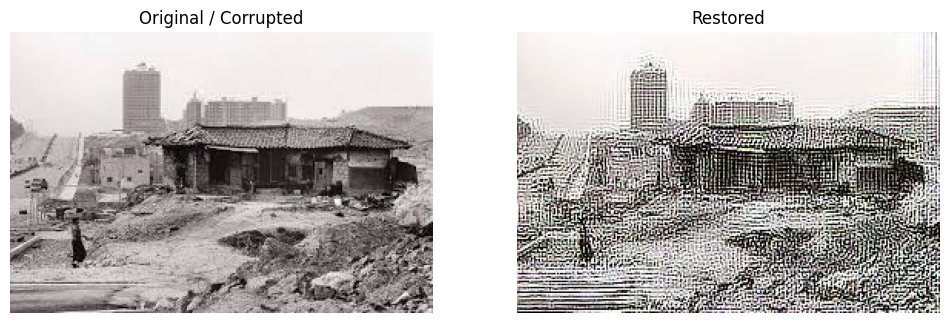

In [28]:
# ======================================
# visualize_results.py
# ======================================

import os
from PIL import Image
import matplotlib.pyplot as plt

# ====== 경로 설정 ======
INPUT_FOLDER = "/content/drive/MyDrive/Advanced_Project/test_images"
OUTPUT_FOLDER = "/content/drive/MyDrive/Advanced_Project/test_results"

# ====== 이미지 파일 리스트 ======
image_files = sorted([f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith((".png", ".jpg", ".jpeg"))])

# ====== 시각화 ======
for fname in image_files:
    input_path = os.path.join(INPUT_FOLDER, fname)
    output_path = os.path.join(OUTPUT_FOLDER, fname)

    input_img = Image.open(input_path).convert("RGB")
    output_img = Image.open(output_path).convert("RGB")

    # 좌우 비교
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(input_img)
    axes[0].set_title("Original / Corrupted")
    axes[0].axis("off")

    axes[1].imshow(output_img)
    axes[1].set_title("Restored")
    axes[1].axis("off")

    plt.show()
